In [1]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest
from datetime import timedelta, date
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller

##### Fetching data and cleaning

In [2]:
def fetch_spot_data_binance(symbol, interval, startTimes, limit):
    url = 'https://data-api.binance.vision/api/v3/klines'
    
    asset_data_binance = {
        'Time' : [],
        'Open' : [],
    } 
    
    for startTime in startTimes:
        params = {
            'symbol' : symbol,
            'interval' : interval,
            'startTime' : startTime,
            'limit' : limit
        }
    
        response = requests.get(url, params)
        partial_data = response.json()
    
        for entry in partial_data:
             asset_data_binance['Time'].append(float(entry[0]))
             asset_data_binance['Open'].append(float(entry[1]))

    return asset_data_binance

def fetch_spot_data_bitget(symbol, granularity, endTimes, limit):
    url = 'https://api.bitget.com/api/v2/spot/market/history-candles'

    asset_data_bitget = {
        'Time' : [],
        'Open' : []
    }
    
    pause_timer = 0    
    for endTime in endTimes:
        params = {
                'symbol' : symbol,
                'granularity' : granularity,
                'endTime' : endTime,
                'limit' : limit
            }
        pause_timer += 1
        if pause_timer == 18:
            time.sleep(0.5)
            pause_timer = 0
            
        response = requests.get(url, params)
        if response.status_code == 200:
            pre_partial_data = response.json()
            if 'data' in pre_partial_data:
                partial_data = pre_partial_data['data']
                for entry in partial_data:
                    asset_data_bitget['Time'].append(float(entry[0]))
                    asset_data_bitget['Open'].append(float(entry[1]))

    return asset_data_bitget

def fetch_options_data():
    url = 'https://history.deribit.com/api/v2/public/get_instruments'
    params = {
        'currency' : 'BTC',
        'kind' : 'option',
        'expired' : 'true'
    }
    
    response = requests.get(url, params)
    options_data = response.json()

    return options_data.get('result',[])

def trades_per_instrument(instruments_name, start_timestamp, end_timestamp):
    instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

    instruments_trade = {instrument_name : [] for instrument_name in instruments_name}
    
    for instrument_name in instruments_name:
        params = {
            'instrument_name': instrument_name,
            'start_timestamp': start_timestamp,
            'end_timestamp': end_timestamp,
            'count': 25,  # Adjust as needed
            'sorting': 'asc'
        }
    
        response = requests.get(instruments_url, params=params)
        data = response.json()
        trades = data.get('result', {}).get('trades', [])

        for trade in trades:
            instruments_trade['instrument_name'].append(trade)        

In [3]:
#Params needed for fetching the spot data.
endTime_0 = int(datetime.datetime(2024, 11, 1).timestamp() * 1000)
start_date = int(datetime.datetime(2018, 8, 18).timestamp() * 1000)

n_hours_to_get = int((endTime_0 - start_date) / (1000 * 60 * 60))

symbol = 'BTCUSDT'
interval = granularity = '1h'
startTimes = [start_date]
endTimes = [endTime_0] #At the end, this list has to have 270+ values, because there are 263 intervals of 200 hours between start_date and endTime_0 (at least)
limit_binance = 1000
limit_bitget = 200

n_requests_binance = int(n_hours_to_get / limit_binance)
n_requests_bitget = int(n_hours_to_get / limit_bitget)
time_interval_binance = 60*60 * 1000 * limit_binance
time_interval_bitget = 60*60 * 1000 * limit_bitget

interval_to_ms = {
    '1h': 60 * 60 * 1000,
    '4h': 4 * 60 * 60 * 1000,
    '6h': 6 * 60 * 60 * 1000,
    '12h': 12 * 60 * 60 * 1000,
    '1d': 24 * 60 * 60 * 1000,
}

asset_data = {}

for i in range(n_requests_binance):
    startTimes.append(startTimes[-1] + time_interval_binance)
for i in range(n_requests_bitget):
    endTimes.insert(0, endTimes[0] - time_interval_bitget)
    

asset_data_binance = fetch_spot_data_binance(symbol, interval, startTimes, limit_binance)
asset_data_bitget = fetch_spot_data_bitget(symbol, granularity, endTimes, limit_bitget)

initial_df_binance = pd.DataFrame(asset_data_binance)
initial_df_bitget = pd.DataFrame(asset_data_bitget)

initial_df_binance['Date'] = pd.to_datetime(initial_df_binance['Time'], unit = 'ms')
initial_df_binance.set_index('Date', inplace = True)
initial_df_binance = initial_df_binance.sort_index()

initial_df_bitget['Date'] = pd.to_datetime(initial_df_bitget['Time'], unit = 'ms')
initial_df_bitget.set_index('Date', inplace = True)
initial_df_bitget = initial_df_bitget.sort_index()

In [4]:
initial_df = pd.concat([initial_df_binance,initial_df_bitget])
initial_df = initial_df.sort_index()
initial_df = initial_df.drop_duplicates(subset = 'Time')

diff = initial_df['Time'].diff().iloc[1]  
missing = (initial_df['Time'].diff() != diff).sum() - 1 
#If missing = 0, there is no data missing, if missing != 0, there is at least one hour of data missing, probably more.

In [5]:
pd.set_option('display.max_columns', 114)

##### Data transformation and statistical analysis

In [15]:
initial_df = initial_df.iloc[9:]
#The initial_df starts at 23:00, I want it to start at 08:00.
df_1h = initial_df.copy()
df_4h = initial_df.resample('4h', origin = 'start').first().copy()
df_6h = initial_df.resample('6h', origin = 'start').first().copy()
df_12h = initial_df.resample('12h', origin = 'start').first().copy()
df_1d = initial_df.resample('1D', origin = 'start').first().copy()

df_1h['returns'] = df_1h['Open'].pct_change()
df_4h['returns'] = df_4h['Open'].pct_change()
df_6h['returns'] = df_6h['Open'].pct_change()
df_12h['returns'] = df_12h['Open'].pct_change()
df_1d['returns'] = df_1d['Open'].pct_change()

window_1h = [24, 48, 72, 96, 120]
window_4h = [24, 30, 36, 42, 48]
window_6h = [16, 20, 24, 28, 32]
window_12h = [14, 28, 42, 56, 70]
window_1d = [7, 14, 30, 60, 90]

for window in window_1h:
    df_1h[f'Volatility_{window}'] = df_1h['returns'].rolling(window=window).std()
    df_1h[f'Log_Volatility_{window}'] = np.log(df_1h[f'Volatility_{window}'])
for window in window_4h:
    df_4h[f'Volatility_{window}'] = df_4h['returns'].rolling(window=window).std()
    df_4h[f'Log_Volatility_{window}'] = np.log(df_4h[f'Volatility_{window}'])
for window in window_6h:
    df_6h[f'Volatility_{window}'] = df_6h['returns'].rolling(window=window).std()
    df_6h[f'Log_Volatility_{window}'] = np.log(df_6h[f'Volatility_{window}'])
for window in window_12h:
    df_12h[f'Volatility_{window}'] = df_12h['returns'].rolling(window=window).std()
    df_12h[f'Log_Volatility_{window}'] = np.log(df_12h[f'Volatility_{window}'])
for window in window_1d:
    df_1d[f'Volatility_{window}'] = df_1d['returns'].rolling(window=window).std()
    df_1d[f'Log_Volatility_{window}'] = np.log(df_1d[f'Volatility_{window}'])

df_1h = df_1h.dropna()
df_4h = df_4h.dropna()
df_6h = df_6h.dropna()
df_12h = df_12h.dropna()
df_1d = df_1d.dropna()

In [16]:
def calculate_adf(series):
    result = adfuller(series.dropna())  # Drop NaNs before ADF test
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

adf_results = {}

# List of dataframes and their respective window lists
timeframes = {
    '1h': (df_1h, window_1h),
    '4h': (df_4h, window_4h),
    '6h': (df_6h, window_6h),
    '12h': (df_12h, window_12h),
    '1d': (df_1d, window_1d),
}

for timeframe, (df, windows) in timeframes.items():
    for window in windows:
        column = f'Volatility_{window}'
        if column in df.columns:
            adf_results[f'{timeframe}_{column}'] = calculate_adf(df[column])

In [17]:
adf_results

{'1h_Volatility_24': {'ADF Statistic': -13.322219342239624,
  'p-value': 6.424769453996244e-25,
  'Critical Values': {'1%': -3.4304689127239567,
   '5%': -2.8615925570870453,
   '10%': -2.5667979743808957}},
 '1h_Volatility_48': {'ADF Statistic': -11.38486022018111,
  'p-value': 8.338025198034606e-21,
  'Critical Values': {'1%': -3.430468914886343,
   '5%': -2.8615925580427586,
   '10%': -2.5667979748895933}},
 '1h_Volatility_72': {'ADF Statistic': -13.718414897942024,
  'p-value': 1.200626525940941e-25,
  'Critical Values': {'1%': -3.430468917048808,
   '5%': -2.8615925589985065,
   '10%': -2.5667979753983095}},
 '1h_Volatility_96': {'ADF Statistic': -13.059894863171245,
  'p-value': 2.0577803986249423e-24,
  'Critical Values': {'1%': -3.4304688867814535,
   '5%': -2.8615925456211984,
   '10%': -2.5667979682779687}},
 '1h_Volatility_120': {'ADF Statistic': -11.984536768000222,
  'p-value': 3.639039154938241e-22,
  'Critical Values': {'1%': -3.4304689019132044,
   '5%': -2.861592552309

In [18]:
df_1d['Log_Volatility_90'] = np.log(df_1d['Volatility_90'])
df_1d['Log_Volatility_90_diff'] = df_1d['Log_Volatility_90'].diff()
adf_log_diff = calculate_adf(df_1d['Log_Volatility_90_diff'])
print(adf_log_diff)

{'ADF Statistic': -12.294824448056453, 'p-value': 7.681350776412389e-23, 'Critical Values': {'1%': -3.433329953061165, '5%': -2.8628564476416725, '10%': -2.5674708095410446}}


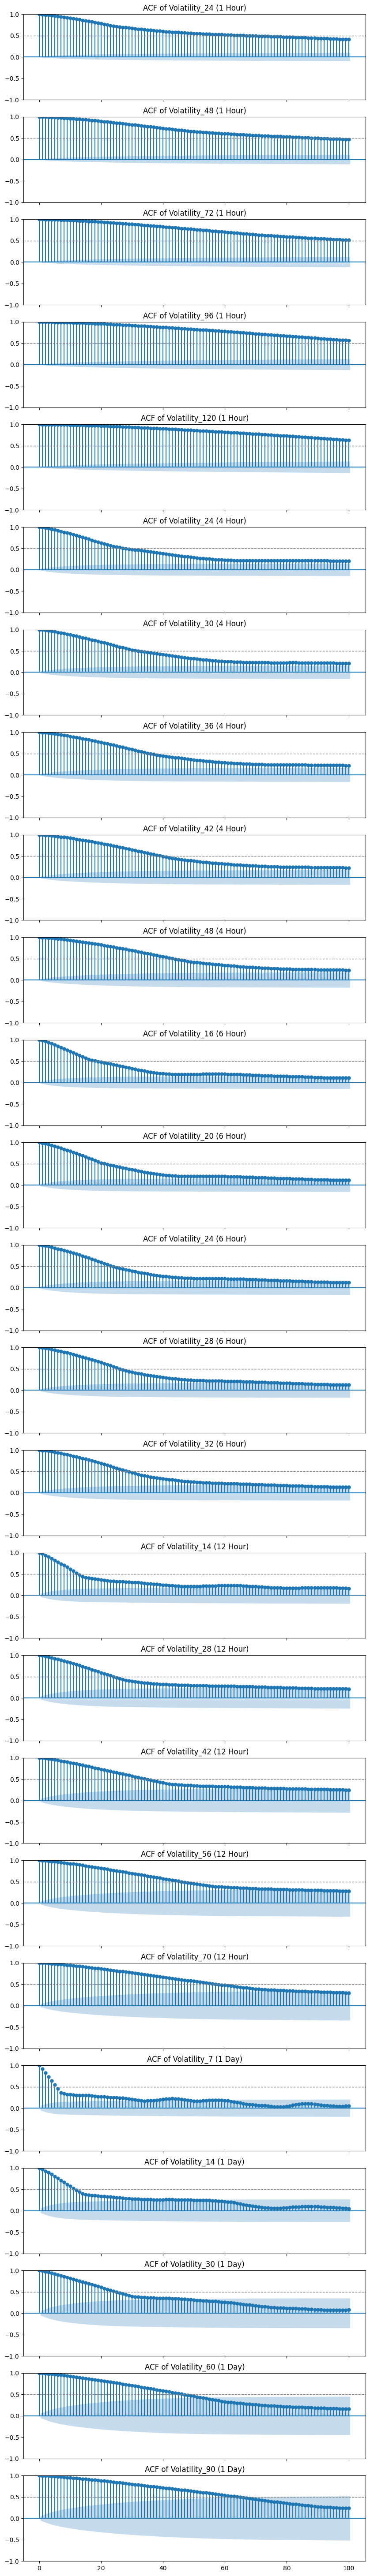

In [19]:
dataframes = [df_1h, df_4h, df_6h, df_12h, df_1d]
titles = ["1 Hour", "4 Hour", "6 Hour", "12 Hour", "1 Day"]
window_sets = {
    "1 Hour": [24, 48, 72, 96, 120],
    "4 Hour": [24, 30, 36, 42, 48],
    "6 Hour": [16, 20, 24, 28, 32],
    "12 Hour": [14, 28, 42, 56, 70],
    "1 Day": [7, 14, 30, 60, 90],
}

# Plot the ACF for all volatility measures
fig, axes = plt.subplots(
    nrows=sum(len(windows) for windows in window_sets.values()), 
    ncols=1, 
    figsize=(10, 75), 
    sharex=True
)

row_idx = 0  # Track the current subplot index
for df, title in zip(dataframes, titles):
    for window in window_sets[title]:
        column_name = f"Volatility_{window}"
        plot_acf(df[column_name].dropna(), lags=100, alpha=0.01, ax=axes[row_idx])
        axes[row_idx].set_title(f"ACF of {column_name} ({title})")
        axes[row_idx].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        row_idx += 1

plt.show()

In [20]:
#I'm not even sure I know or understand what this does, but it seems to work.
def calculate_shift(current_hour, lookahead_hours, frequency):
    """
    Calculate the number of rows to shift based on the current hour,
    lookahead period, and data frequency.
    
    Args:
    - current_hour (int): The current hour of the row.
    - lookahead_hours (int): The target lookahead period in hours.
    - frequency (int): The data frequency in hours (e.g., 1 for 1H, 4 for 4H).

    Returns:
    - int: The number of rows to shift.
    """
    if current_hour < 8:
        shift = lookahead_hours + (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        shift = lookahead_hours - (current_hour - 8)
    elif current_hour >= 20:
        shift = lookahead_hours + 8 + 24 - current_hour
    else:
        shift = lookahead_hours
    return int(shift / frequency)

#General function to create future Open price columns
def add_future_open(df, lookahead_hours_list, frequency):
    """
    Add future Open price columns for given lookahead periods.

    Args:
    - df (pd.DataFrame): The DataFrame containing 'Datetime' and 'Open'.
    - lookahead_hours_list (list): List of lookahead periods in hours.
    - frequency (int): The data frequency in hours (e.g., 1 for 1H, 4 for 4H).
    """
    df['Datetime'] = pd.to_datetime(df['Time'], unit='ms')
    for lookahead_hours in lookahead_hours_list:
        col_name = f'Open_{lookahead_hours}h'
        df[col_name] = np.nan
        for i in range(len(df)):
            current_hour = df.iloc[i]['Datetime'].hour
            n_rows_to_shift = calculate_shift(current_hour, lookahead_hours, frequency)
            target_index = i + n_rows_to_shift
            if target_index < len(df):
                df.loc[df.index[i], col_name] = df.iloc[target_index]['Open']

#Apply function to data
add_future_open(df_1h, [48, 72, 96], 1)  #1-hour frequency
add_future_open(df_4h, [72, 96, 120], 4)  #4-hour frequency
add_future_open(df_6h, [96, 120, 144], 6)
add_future_open(df_12h, [120, 144, 168], 12)
add_future_open(df_1d, [168, 240, 480], 24)

In [40]:
df_1h.head()

,Time,Open,returns,Volatility_24,Log_Volatility_24,Volatility_48,Log_Volatility_48,Volatility_72,Log_Volatility_72,Volatility_96,Log_Volatility_96,Volatility_120,Log_Volatility_120,Datetime,Open_48h,Open_72h,Open_96h,Log_Volatility_24_20th_percent,Log_Volatility_24_80th_percent,Move_1,Move_2,Move_3,Log_Volatility_48_20th_percent,Log_Volatility_48_80th_percent,Log_Volatility_72_20th_percent,Log_Volatility_72_80th_percent,Log_Volatility_96_20th_percent,Log_Volatility_96_80th_percent,Log_Volatility_120_20th_percent,Log_Volatility_120_80th_percent
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-15 17:00:00,1.534352e+12,6598.77,0.026806,0.008041,-4.823232,0.008828,-4.729878,0.007933,-4.836785,0.009562,-4.649949,0.009344,-4.672975,2018-08-15 17:00:00,6490.74,6460.46,6351.7,0,1,-1.686375,-3.951646,-3.379872,0,1,0,0,0,1,0,1
2018-08-15 18:00:00,1.534356e+12,6567.84,-0.004687,0.008229,-4.800138,0.008752,-4.738488,0.007937,-4.836180,0.007983,-4.830421,0.009309,-4.676748,2018-08-15 18:00:00,6490.74,6460.46,6351.7,0,1,-0.838327,-3.531755,-3.246730,0,1,0,0,0,0,0,1
2018-08-15 19:00:00,1.534360e+12,6521.40,-0.007071,0.008510,-4.766556,0.008832,-4.729420,0.007965,-4.832695,0.007958,-4.833565,0.009319,-4.675678,2018-08-15 19:00:00,6490.74,6460.46,6351.7,0,1,-0.119146,-2.521084,-2.432913,0,1,0,0,0,0,0,1
2018-08-15 20:00:00,1.534363e+12,6374.49,-0.022527,0.009971,-4.608079,0.009461,-4.660607,0.008407,-4.778694,0.008291,-4.792625,0.009547,-4.651493,2018-08-15 20:00:00,6460.46,6351.70,6458.0,0,1,2.005964,-0.021649,0.015217,0,1,0,1,0,1,0,1
2018-08-15 21:00:00,1.534367e+12,6362.34,-0.001906,0.009966,-4.608619,0.009445,-4.662315,0.008410,-4.778370,0.008283,-4.793551,0.009079,-4.701749,2018-08-15 21:00:00,6460.46,6351.70,6458.0,0,1,1.907317,0.027663,2.588199,0,1,0,1,0,1,0,1


In [21]:
def calculate_static_percentiles(df, volatility_col, percentiles):
    """
    Calculate specified static percentiles for a given volatility column in a DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - volatility_col (str): Column name to calculate percentiles for.
    - percentiles (list): List of percentiles to calculate.

    Returns:
    - dict: Dictionary with percentile as key and value as calculated value.
    """
    return {p: np.percentile(df[volatility_col], p) for p in percentiles}

# Function to add move and percentile columns
def add_move_and_percentile_columns(df, shifts, percentiles, static_percentiles, volatility_col):
    """
    Add columns for percentage moves and percentile-based flags for a specific volatility column.

    Args:
    - df (pd.DataFrame): DataFrame to modify.
    - shifts (dict): Mapping of move column names to shift periods.
    - percentiles (dict): Mapping of percentiles to static values.
    - static_percentiles (dict): Static percentile values for the DataFrame.
    - volatility_col (str): Column name for volatility.
    """
    for col_name, shift_period in shifts.items():
        df[col_name] = ((df['Open'].shift(-shift_period) / df['Open']) - 1) * 100

# Define volatility columns for each timeframe
volatility_columns = {
    '1h': ['Log_Volatility_24', 'Log_Volatility_48', 'Log_Volatility_72', 'Log_Volatility_96', 'Log_Volatility_120'],
    '4h': ['Log_Volatility_24', 'Log_Volatility_30', 'Log_Volatility_36', 'Log_Volatility_42', 'Log_Volatility_48'],
    '6h': ['Log_Volatility_16', 'Log_Volatility_20', 'Log_Volatility_24', 'Log_Volatility_28', 'Log_Volatility_32'],
    '12h': ['Log_Volatility_14', 'Log_Volatility_28', 'Log_Volatility_42', 'Log_Volatility_56', 'Log_Volatility_70'],
    '1d': ['Log_Volatility_7', 'Log_Volatility_14', 'Log_Volatility_30', 'Log_Volatility_60', 'Log_Volatility_90']
}

# Define shifts for each timeframe
shifts_dict = {
    '1h': {'Move_1': 48, 'Move_2': 72, 'Move_3' : 96},
    '4h': {'Move_1': 18, 'Move_2': 24, 'Move_3' : 30},  # 72h/4h = 18 rows, 96h/4h = 24 rows
    '6h': {'Move_1': 16, 'Move_2': 20, 'Move_3' : 24},  # 96h/6h = 16 rows, 120h/6h = 20 rows
    '12h': {'Move_1': 10, 'Move_2': 12, 'Move_3' : 14}, # 5d/12h = 10 rows, 7d/12h = 14 rows
    '1d': {'Move_1': 7, 'Move_2': 10, 'Move_3': 20}  # 7d, 10d, 20d
}

# Process each DataFrame
timeframes = {'1h': df_1h, '4h': df_4h, '6h': df_6h, '12h': df_12h, '1d': df_1d}
percentiles = [20, 80]

for tf, df in timeframes.items():
    volatility_cols = volatility_columns[tf]  # List of volatility columns
    shifts = shifts_dict[tf]

    for volatility_col in volatility_cols:  # Loop through each volatility column
        # Calculate static percentiles for the current column
        static_percentiles = calculate_static_percentiles(df, volatility_col, percentiles)

        # Add percentile-based columns for the current volatility column
        for percentile in percentiles:
            col_name = f'{volatility_col}_{percentile}th_percent'
            df[col_name] = (df[volatility_col] < static_percentiles[percentile]).astype(int) if percentile == 20 else \
                           (df[volatility_col] > static_percentiles[percentile]).astype(int)

        # Add percentage move columns
        add_move_and_percentile_columns(df, shifts, percentiles, static_percentiles, volatility_col)

    # For timeframes 6h, 12h, and 1d, set 'Date' as index
    if tf in ['6h', '12h', '1d']:
        df['Date'] = pd.to_datetime(df['Time'], unit='ms')
        df.set_index('Date', inplace=True)

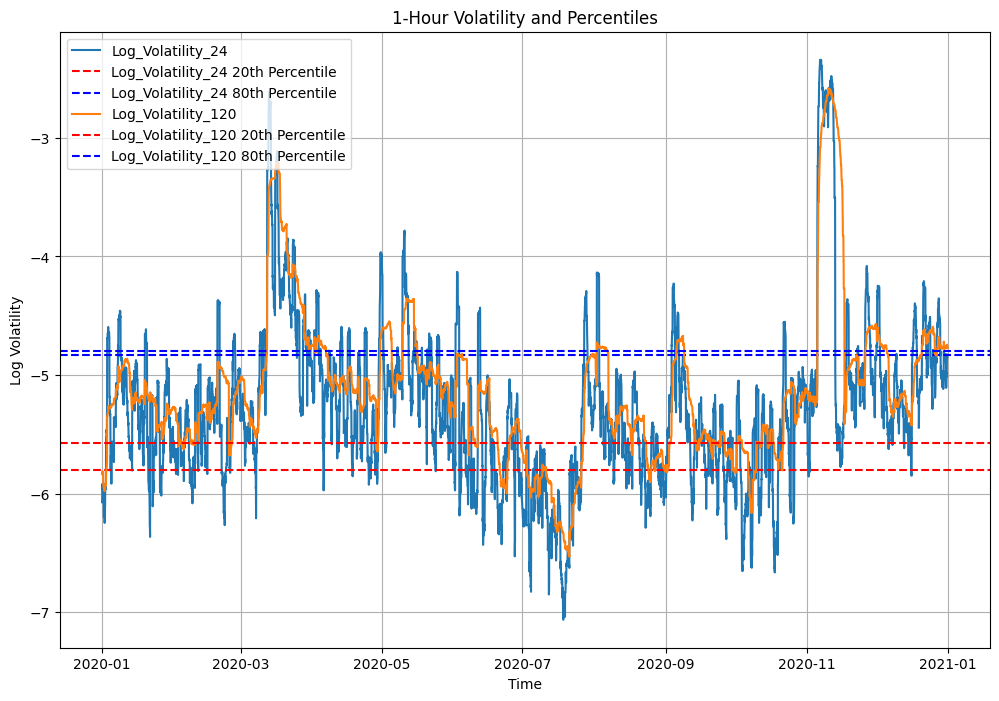

In [41]:
def calculate_percentiles(df, volatility_columns, percentiles=[20, 80]):
    percentile_dict = {}
    for col in volatility_columns:
        percentile_dict[col] = {p: np.percentile(df[col], p) for p in percentiles}
    return percentile_dict

# Example: for 1-hour timeframe
volatility_cols = ['Log_Volatility_24', 'Log_Volatility_120']
percentiles = calculate_percentiles(df_1h, volatility_cols, percentiles=[20, 80])

def plot_volatility_with_percentiles(df, volatility_columns, percentiles, title, start = None, end = None):
    if start and end:
        df = df[(df['Datetime'] >= start) & (df['Datetime'] <= end)]
    
    plt.figure(figsize=(12, 8))
    
    for col in volatility_columns:
        plt.plot(df['Datetime'], df[col], label=f'{col}', alpha=1)
        # Add percentile lines
        p20 = percentiles[col][20]
        p80 = percentiles[col][80]
        plt.axhline(y=p20, color='red', linestyle='--', label=f'{col} 20th Percentile')
        plt.axhline(y=p80, color='blue', linestyle='--', label=f'{col} 80th Percentile')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Log Volatility')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# Example: Plot for 1-hour timeframe
plot_volatility_with_percentiles(df_1h, volatility_cols, percentiles, "1-Hour Volatility and Percentiles", '2020-01-01', '2021-01-01')

In [11]:
signal_days_1h = df_1h.loc[df_1h['20th_percent'] == 1, 'Time'].unique()
signal_days_1h = sorted(signal_days_1h)
high_days_1h = df_1h.loc[df_1h['80th_percent'] == 1, 'Time'].unique()
high_days_1h = sorted(high_days_1h)

signal_days_4h = df_4h.loc[df_4h['20th_percent'] == 1, 'Time'].unique()
signal_days_4h = sorted(signal_days_4h)
high_days_4h = df_4h.loc[df_4h['80th_percent'] == 1, 'Time'].unique()
high_days_4h = sorted(high_days_4h)

signal_days_6h = df_6h.loc[df_6h['20th_percent'] == 1, 'Time'].unique()
signal_days_6h = sorted(signal_days_6h)
high_days_6h = df_6h.loc[df_6h['80th_percent'] == 1, 'Time'].unique()
high_days_6h = sorted(high_days_6h)

signal_days_12h = df_12h.loc[df_12h['20th_percent'] == 1, 'Time'].unique()
signal_days_12h = sorted(signal_days_12h)
high_days_12h = df_12h.loc[df_12h['80th_percent'] == 1, 'Time'].unique()
high_days_12h = sorted(high_days_12h)

signal_days_1d = df_1d.loc[df_1d['20th_percent'] == 1, 'Time'].unique()
signal_days_1d = sorted(signal_days_1d)
high_days_1d = df_1d.loc[df_1d['80th_percent'] == 1, 'Time'].unique()
high_days_1d = sorted(high_days_1d)

df_1h_low = df_1h[df_1h['Time'].isin(signal_days_1h)]
df_4h_low = df_4h[df_4h['Time'].isin(signal_days_4h)]
df_6h_low = df_6h[df_6h['Time'].isin(signal_days_6h)]
df_12h_low = df_12h[df_12h['Time'].isin(signal_days_12h)]
df_1d_low = df_1d[df_1d['Time'].isin(signal_days_1d)]

df_1h_high = df_1h[df_1h['Time'].isin(high_days_1h)]
df_4h_high = df_4h[df_4h['Time'].isin(high_days_4h)]
df_6h_high = df_6h[df_6h['Time'].isin(high_days_6h)]
df_12h_high = df_12h[df_12h['Time'].isin(high_days_12h)]
df_1d_high = df_1d[df_1d['Time'].isin(high_days_1d)]


signal_days_1h_72h = [i + 72*60*60 * 1000 for i in signal_days_1h]

In [12]:
mean_1h_1 = np.mean(df_1h_low['Move_1'])
mean_1h_2 = np.mean(df_1h_low['Move_2'])
std_1h_1 = df_1h_low['Move_1'].std()
std_1h_2 = df_1h_low['Move_2'].std()

mean_4h_1 = np.mean(df_4h_low['Move_1'])
mean_4h_2 = np.mean(df_4h_low['Move_2'])
std_4h_1 = df_4h_low['Move_1'].std()
std_4h_2 = df_4h_low['Move_2'].std()

mean_6h_1 = np.mean(df_6h_low['Move_1'])
mean_6h_2 = np.mean(df_6h_low['Move_2'])
std_6h_1 = df_6h_low['Move_1'].std()
std_6h_2 = df_6h_low['Move_2'].std()

mean_12h_1 = np.mean(df_12h_low['Move_1'])
mean_12h_2 = np.mean(df_12h_low['Move_2'])
std_12h_1 = df_12h_low['Move_1'].std()
std_12h_2 = df_12h_low['Move_2'].std()

mean_1d_1 = np.mean(df_1d_low['Move_1'])
mean_1d_2 = np.mean(df_1d_low['Move_2'])
mean_1d_3 = np.mean(df_1d_low['Move_3'])
std_1d_1 = df_1d_low['Move_1'].std()
std_1d_2 = df_1d_low['Move_2'].std()
std_1d_3 = df_1d_low['Move_3'].std()

print(f'Mean and standard deviation of the Move for 48h lookahead (1h low vol): {mean_1h_1} {std_1h_1}')
print(f'Mean and standard deviation of the Move for 72h lookahead (1h low vol): {mean_1h_2} {std_1h_2}')
print(f'Mean and standard deviation of the Move for 72h lookahead (4h low vol): {mean_4h_1} {std_4h_1}')
print(f'Mean and standard deviation of the Move for 96h lookahead (4h low vol): {mean_4h_2} {std_4h_2}')
print(f'Mean and standard deviation of the Move for 96h lookahead (6h low vol): {mean_6h_1} {std_6h_1}')
print(f'Mean and standard deviation of the Move for 120h lookahead (6h low vol): {mean_6h_2} {std_6h_2}')
print(f'Mean and standard deviation of the Move for 5d lookahead (12h low vol): {mean_12h_1} {std_12h_1}')
print(f'Mean and standard deviation of the Move for 7d lookahead (12h low vol): {mean_12h_2} {std_12h_2}')
print(f'Mean and standard deviation of the Move for 7d lookahead (1d low vol): {mean_1d_1} {std_1d_1}')
print(f'Mean and standard deviation of the Move for 10d lookahead (1d low vol): {mean_1d_2} {std_1d_2}')
print(f'Mean and standard deviation of the Move for 30d lookahead (1d low vol): {mean_1d_3} {std_1d_3}')

Mean and standard deviation of the Move for 48h lookahead (1h low vol): 0.2100698393142737 3.747069802178565
Mean and standard deviation of the Move for 72h lookahead (1h low vol): 0.39627331250066794 4.710899997582515
Mean and standard deviation of the Move for 72h lookahead (4h low vol): 0.5691166396073039 4.752507025742552
Mean and standard deviation of the Move for 96h lookahead (4h low vol): 0.7419682640630437 5.628064499771764
Mean and standard deviation of the Move for 96h lookahead (6h low vol): 0.9895720990081085 5.529006408838985
Mean and standard deviation of the Move for 120h lookahead (6h low vol): 1.2835997071518994 6.309945830004927
Mean and standard deviation of the Move for 5d lookahead (12h low vol): 1.1476252650433678 6.519736556926042
Mean and standard deviation of the Move for 7d lookahead (12h low vol): 1.914522335404071 8.168282754079987
Mean and standard deviation of the Move for 7d lookahead (1d low vol): 1.3280853262383678 8.628329732778676
Mean and standard d

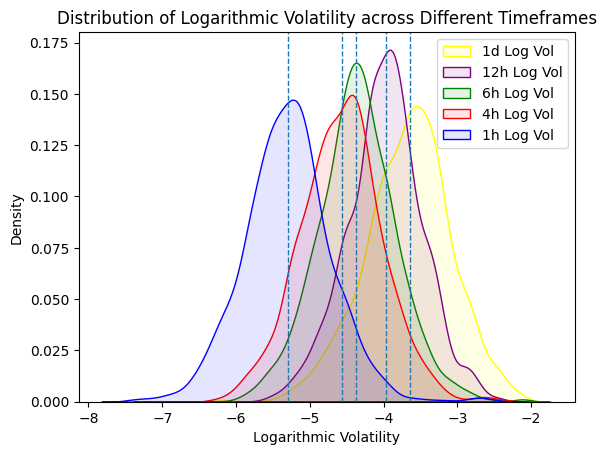

In [67]:
# Resample each DataFrame to daily mean
df_1h_resampled = df_1h.resample('D').mean()
df_4h_resampled = df_4h.resample('D').mean()
df_6h_resampled = df_6h.resample('D').mean()
df_12h_resampled = df_12h.resample('D').mean()
df_1d_resampled = df_1d.resample('D').mean()

# Create a new DataFrame combining all volatility data
all_log_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1h_resampled['Log_Volatility'], df_4h_resampled['Log_Volatility'],
        df_6h_resampled['Log_Volatility'], df_12h_resampled['Log_Volatility'],
        df_1d_resampled['Log_Volatility']
    ]),
    'Category': ['1h'] * len(df_1h_resampled) + ['4h'] * len(df_4h_resampled) +
                ['6h'] * len(df_6h_resampled) + ['12h'] * len(df_12h_resampled) +
                ['1d'] * len(df_1d_resampled)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_log_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, hue_order=['1h', '4h', '6h', '12h', '1d'], alpha = 0.1)

# Add vertical lines for the median of each distribution
for category in ['1h', '4h', '6h', '12h', '1d']:
    median_value = all_log_volatility[all_log_volatility['Category'] == category]['Volatility'].median()
    plt.axvline(median_value, linestyle='--', linewidth=1)

plt.title('Distribution of Logarithmic Volatility across Different Timeframes')
plt.xlabel('Logarithmic Volatility')
plt.ylabel('Density')
plt.legend(['1d Log Vol', '12h Log Vol', '6h Log Vol', '4h Log Vol', '1h Log Vol'])  # Adding legend to differentiate categories
plt.show()

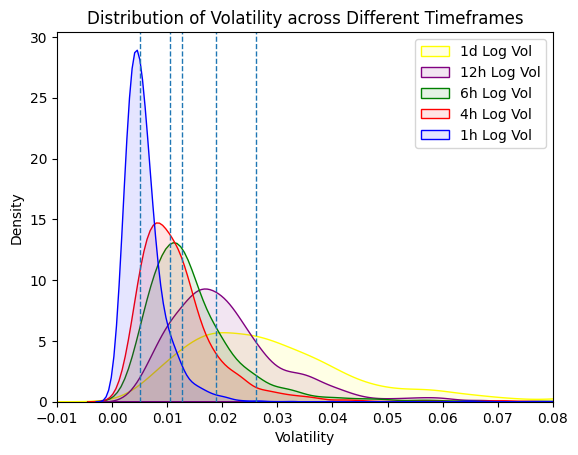

In [64]:
# Resample each DataFrame to daily mean
df_1h_resampled = df_1h.resample('D').mean()
df_4h_resampled = df_4h.resample('D').mean()
df_6h_resampled = df_6h.resample('D').mean()
df_12h_resampled = df_12h.resample('D').mean()
df_1d_resampled = df_1d.resample('D').mean()

# Create a new DataFrame combining all volatility data
all_volatility = pd.DataFrame({
    'Volatility': pd.concat([
        df_1h_resampled['Volatility'], df_4h_resampled['Volatility'],
        df_6h_resampled['Volatility'], df_12h_resampled['Volatility'],
        df_1d_resampled['Volatility']
    ]),
    'Category': ['1h'] * len(df_1h_resampled) + ['4h'] * len(df_4h_resampled) +
                ['6h'] * len(df_6h_resampled) + ['12h'] * len(df_12h_resampled) +
                ['1d'] * len(df_1d_resampled)
})

# Plot KDE with specified order and fill
sns.kdeplot(data=all_volatility, x='Volatility', hue='Category', palette=['blue', 'red', 'green', 'purple', 'yellow'], fill=True, hue_order=['1h', '4h', '6h', '12h', '1d'], alpha=0.1)

# Add vertical lines for the median of each distribution
for category in ['1h', '4h', '6h', '12h', '1d']:
    median_value = all_volatility[all_volatility['Category'] == category]['Volatility'].median()
    plt.axvline(median_value, linestyle='--', linewidth=1)

plt.title('Distribution of Volatility across Different Timeframes')
plt.xlabel('Volatility')
plt.xlim(-0.01,0.08)
plt.ylabel('Density')
plt.legend(['1d Log Vol', '12h Log Vol', '6h Log Vol', '4h Log Vol', '1h Log Vol'])  # Adding legend to differentiate categories
plt.show()

##### Fetching options data

In [ ]:
options_data = fetch_options_data()

In [ ]:
options_data[0]

In [ ]:
options_data = pd.DataFrame(options_data)
options_data.drop(columns = 
                  ['tick_size_steps','tick_size','settlement_period','settlement_currency',
                   'rfq','settlement_currency','price_index','instrument_id',
                   'creation_timestamp','counter_currency','contract_size','block_trade_tick_size',
                   'block_trade_min_trade_amount','block_trade_commission','base_currency','kind','is_active'],inplace=True) 

options_data['Date'] = (pd.to_datetime(options_data['expiration_timestamp'], unit = 'ms'))
options_data = options_data[options_data['Date'].dt.hour == 8]
options_data = options_data[options_data['option_type'] == 'call']
options_data['Date'] = options_data['Date'].dt.date
#options_data_1h.set_index('Date', inplace = True)

options_data.drop(columns = 
                  ['quote_currency', 'option_type', 'min_trade_amount'],inplace=True) 

options_data_1h = options_data[options_data['expiration_timestamp'].isin(signal_days_1h_72h)]

In [ ]:
df_1h.loc[:,'Adjusted_date'] = np.where(
    df_1h['Datetime'].dt.hour < 20,
    df_1h['Datetime'].dt.date,
    (df_1h['Datetime'] + pd.Timedelta(days=1)).dt.date
)

df_1h = df_1h[~df_1h['Adjusted_date'].duplicated()].copy()

In [ ]:
options_data_1h.head(25)

In [ ]:
df_1h.head(20)

In [ ]:
butterfly_options = {}

for i in range(len(df_1h)):
    instrument_names = []
    instrument_strikes = []
    day = df_1h.iloc[i]['Adjusted_date'] + pd.Timedelta(days=3)
    day_open = df_1h.iloc[i]['Open']

    matching_rows = options_data_1h[options_data_1h['Date'] == day]
    
    if not matching_rows.empty:
        instrument_names = matching_rows['instrument_name'].tolist()
        instrument_strikes = matching_rows['strike'].tolist()

        closest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open))
        lowest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 0.95))
        highest_index = min(range(len(instrument_strikes)), key=lambda x: abs(instrument_strikes[x] - day_open * 1.05))

        closest_name = instrument_names[closest_index]
        lowest_name = instrument_names[lowest_index]
        highest_name = instrument_names[highest_index]

        butterfly_options[day] = {
            'lowest' : lowest_name,
            'closest' : closest_name,
            'highest' : highest_name        
        }

In [ ]:
print(len(instrument_names), len(instrument_strikes))

In [ ]:
butterfly_options